In [1]:
import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
import json
import sys
import p_tqdm
import json
import seaborn as sns
import multiprocessing
sys.path.append('/inwdata2/Prithvi/GIT/analytics/')
%load_ext autoreload
%autoreload 2

/inwdata2/Prithvi/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EEC analysis for 69k videos

## reading global csv data

In [2]:
global_mined_data = pd.read_csv('/inwdata2/Prithvi/GIT/work/AN25908/avid_uuid_s3_path.csv')
global_mined_data = global_mined_data.drop(columns=['alert_id', 'event_code', 's3_bucket']) # dropping unnecessary columns

# avid, uuid, avid_folder_name set to string
global_mined_data['avid'] = global_mined_data['avid'].astype(str)
global_mined_data['uuid'] = global_mined_data['uuid'].astype(str)
global_mined_data['avid_folder_name'] = global_mined_data['avid_folder_name'].astype(str)

# start_timestamp and end_timestamp to int
global_mined_data['start_timestamp'] = global_mined_data['start_timestamp'].astype(int)
global_mined_data['end_timestamp'] = global_mined_data['end_timestamp'].astype(int)

# formatting uuid to standard format
global_mined_data['uuid'] = global_mined_data['uuid'].apply(lambda temp_uuid: f"{temp_uuid[:8]}-{temp_uuid[8:12]}-{temp_uuid[12:16]}-{temp_uuid[16:20]}-{temp_uuid[20:]}") 
print(f"Global mined data shape: {global_mined_data.shape}")

Global mined data shape: (217040, 5)


In [3]:
global_mined_data[global_mined_data['uuid'] == '400b69e7-4940-4e72-85b0-d649850496c0']

,avid,avid_folder_name,start_timestamp,end_timestamp,uuid
72452,fc01b3dc-5ca5-46d4-925d-a3f9c19e3580,fc01b3dc-5ca5-46d4-925d-a3f9c19e3580__39748676,29900,31900,400b69e7-4940-4e72-85b0-d649850496c0


## analysis for duration which are between 1700 to 2500

### reading annotation data

In [4]:
annotations_df = pd.read_csv('/inwdata2/Prithvi/GIT/work/AN25908/eec_annotations.csv')
print(f"Annotations dataframe shape: {annotations_df.shape}")
# annotations_df.set_index('uuid', inplace=True)
annotations_df.head()

Annotations dataframe shape: (318, 11)


,uuid,start_frame,end_frame,Are_both_eyes_clearly_visible,Eyes_look_COMPLETELY_closed_due_to,Eyes_not_COMPLETELY_closed_then,Is_Camera_placement_valid?,Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?,Is_person_looking_outside_[INVALID_POSE]_or_upside?,Is_person_wearing_any_artifacts?,Is_there_any_obtstruction_or_reflection_in_any_eye?
0,0051e659-80d3-4557-a306-2975eca3b997,20.0000,39.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No
1,00edb13e-db6e-4943-88bb-4ce2d7323a82,0.0000,4.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No
2,00f96ec4-0eb2-4fd4-a0fa-4e78f3a905d2,20.0000,41.0000,Yes,Not_applicable,Eyes_gaze_down,Yes,No,No,Not_Applicable,No
3,011500fd-4bd3-4577-a7b5-598b48475d73,20.0000,44.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No
4,013a3177-d3ea-47c0-969f-9d7e74a431ab,20.0000,59.0000,No,Not_applicable,Eyes_gaze_down,Yes,No,No,Spects,Yes


### Remove uuids

In [5]:
removal_uuids = pd.read_csv('/inwdata2/Prithvi/GIT/work/AN25908/remove_uuids.csv')
print(f"Removal uuids shape: {removal_uuids.shape}")

Removal uuids shape: (10, 1)


In [6]:
# annotations_df = annotations_df[annotations_df['Is_there_any_obtstruction_or_reflection_in_any_eye?'] != 'Yes']
# print(f"Annotations dataframe shape after removing obstruction/reflection cases: {annotations_df.shape}")

In [7]:
# cond1 = annotations_df['Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?'] == 'Yes'
# cond2 = annotations_df['Eyes_look_COMPLETELY_closed_due_to'] == 'Fatigue'
# cond3 = annotations_df['Eyes_look_COMPLETELY_closed_due_to'] == 'Microsleep'
# annotations_df = annotations_df[(cond1 & cond2 & cond3)]
# print(f"Filtered annotations dataframe shape: {annotations_df.shape}")

### Merging annotation and global mined data

In [8]:
evaluation_data = pd.merge(annotations_df, global_mined_data, on='uuid', how='inner')
print(f"Evaluation data shape: {evaluation_data.shape}")
evaluation_data.head()

Evaluation data shape: (318, 15)


,uuid,start_frame,end_frame,Are_both_eyes_clearly_visible,Eyes_look_COMPLETELY_closed_due_to,Eyes_not_COMPLETELY_closed_then,Is_Camera_placement_valid?,Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?,Is_person_looking_outside_[INVALID_POSE]_or_upside?,Is_person_wearing_any_artifacts?,Is_there_any_obtstruction_or_reflection_in_any_eye?,avid,avid_folder_name,start_timestamp,end_timestamp
0,0051e659-80d3-4557-a306-2975eca3b997,20.0000,39.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No,60984baa-4a71-493c-89da-81cbf216db38,60984baa-4a71-493c-89da-81cbf216db38__43416437,29900,31700
1,00edb13e-db6e-4943-88bb-4ce2d7323a82,0.0000,4.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No,fe5268ed-d541-46f8-b2d1-2e62855f1c12,fe5268ed-d541-46f8-b2d1-2e62855f1c12__32980262,0,2500
2,00f96ec4-0eb2-4fd4-a0fa-4e78f3a905d2,20.0000,41.0000,Yes,Not_applicable,Eyes_gaze_down,Yes,No,No,Not_Applicable,No,4e084aa5-4ad5-4e7c-98ab-b32011f72282,4e084aa5-4ad5-4e7c-98ab-b32011f72282__40246183,9600,11600
3,011500fd-4bd3-4577-a7b5-598b48475d73,20.0000,44.0000,Yes,Not_applicable,Open_eyes_more_than_2_frames,Yes,No,No,Not_Applicable,No,ba74fc5b-98c3-4e29-913c-08965f4f37f8,ba74fc5b-98c3-4e29-913c-08965f4f37f8__40941189,5100,7400
4,013a3177-d3ea-47c0-969f-9d7e74a431ab,20.0000,59.0000,No,Not_applicable,Eyes_gaze_down,Yes,No,No,Spects,Yes,6285d472-d35d-4b87-8a2f-9e5681a6b921,6285d472-d35d-4b87-8a2f-9e5681a6b921__39205921,26500,28500


In [9]:
from src.dms.modules.eec_with_obs import ExtendedEyeClosure

ImportError: py_nd_auth.a is not linked properly!! error: libpython3.9.so.1.0: cannot open shared object file: No such file or directory


WARNING - /home/ubuntu/config/deviceconfig.ini has no section identity
WARNING - Unsupported device type: None
Using mod_config: /home/ubuntu/.nddevice/nd_config_mod.ini
Using override_config: /home/ubuntu/config/bagheera_override.ini
Reading config: /inwdata2/Prithvi/GIT/analytics/src/nd_config.ini
WARNING - Cannot import label map for /home/ubuntu/autocam/tycho_yolo_usuk_v6.5.8
WARNING - This should only happen on the cloud side
WARNING - Cannot import label map for /home/ubuntu/autocam/tloc_US_v0.11.0.0.5
WARNING - This should only happen on the cloud side
WARNING - Cannot import label map for /home/ubuntu/autocam/tsc_v1.8.3.4
WARNING - This should only happen on the cloud side
WARNING - Cannot import label map for /home/ubuntu/autocam/rmc_v0.2.0.1.4
WARNING - This should only happen on the cloud side
WARNING - Cannot import label map for /home/ubuntu/autocam/pose_yolo_multihead_v2.0.5.4
WARNING - This should only happen on the cloud side
WARNING - Cannot import label map for /home/

In [10]:
def evaluate_algorithm(each_evaluation_data_row: dict, log_flag=True) -> pd.Series: # each row in evaluation_data
    '''
        Evaluate EEC algorithm performance for a single evaluation data row.
        1. Load detection data from JSON file.
        2. Process detections using ExtendedEyeClosure module.
        3. Compare algorithm observations with ground truth to compute TP, FP, FN, TN
        Args:
            each_evaluation_data_row (dict): A dictionary representing a single row of evaluation data.
            log_flag (bool): Flag to enable or disable logging.
        Returns:
            pd.Series: A pandas Series containing evaluation metrics (TP, FP, FN, TN) and related information.
    '''
    def check_overlap(pred_start, pred_end, gt_start, gt_end) -> bool:
        return max(pred_start, gt_start) < min(pred_end, gt_end)
    
    json_path = f"/inwdata2/Prithvi/AN_25908_eec_recall_improvement/dms_submit_job_141184/{each_evaluation_data_row['avid_folder_name']}/summary.json"
    with open(json_path, 'r') as f:
        json_dict = json.load(f)
    detections = json_dict['inference_data']['dms']['detections']
    eec_module = ExtendedEyeClosure(processfps = 10)
    eec_module.reset_state()
    annotation_alert_window_process_trigger = -1
    ret_dict = {'uuid': each_evaluation_data_row['uuid'], 
                'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0, 
                'st_fidx': -1, 'et_fidx': -1,
                'annotation_alert_window_process_trigger': -1,
                'is_speed_met': -1, 'is_pose_valid': -1, 'is_not_ld': -1}
    
    # Early exit if speed condition is not met
    speed_list = np.array([eachDetection['speed'] for eachDetection in detections])
    if np.min(speed_list[each_evaluation_data_row['start_timestamp']//100 : each_evaluation_data_row['end_timestamp']//100 + 1]) < 10.0:
        ret_dict['is_speed_met'] = 0
        return pd.Series(ret_dict)
    
    for eachDetection in detections:
        start_ts = detections[0]['ts']
        event_obs = eec_module.update(lr_eye_detection_scores = (eachDetection['left_eye_det_scores'], eachDetection['right_eye_det_scores']),
                                      pose = eachDetection['pose_valid'],
                                      nose = eachDetection['nose'],
                                      face_bb = eachDetection['face_bbox'],
                                      ts = eachDetection['ts'] - start_ts,
                                      speed = eachDetection['speed'],
                                      latlong = (0,0),
                                      p_angle = eachDetection.get('p_angle', 0.0),
                                      y_angle = eachDetection.get('y_angle', 0.0),
                                      new_ld_algo = True)
        if each_evaluation_data_row['start_timestamp']//100 <= eachDetection['framenum'] <= each_evaluation_data_row['end_timestamp']//100:
            annotation_alert_window_process_trigger = max(annotation_alert_window_process_trigger, event_obs['process_trigger'])
        if log_flag:
            print(event_obs)
    events, obs_data, eec_end_event_obs = eec_module.serialize_for_session(new_ld_algo = True)

    # if log_flag:
    #     print(f"eva data start timestamp: {each_evaluation_data_row['start_timestamp']} and eva data end timestamp: {each_evaluation_data_row['end_timestamp']}")
    #     print(obs_data['event_info'])
    #     print(events)

    for each_eec_algo_observation_data in obs_data['event_info']:
        overlap_flag = check_overlap(each_eec_algo_observation_data['st_fidx'], each_eec_algo_observation_data['et_fidx'],
                                 each_evaluation_data_row['start_timestamp']//100, each_evaluation_data_row['end_timestamp']//100)
        cond1 = overlap_flag == True
        cond2 = each_evaluation_data_row['Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?'] == 'Yes'
        cond3 = each_eec_algo_observation_data['is_valid_eec'] == True
        if cond1:
            ret_dict['is_speed_met'] = each_eec_algo_observation_data['is_speed_met']
            ret_dict['is_pose_valid'] = each_eec_algo_observation_data['is_pose_valid']
            ret_dict['is_not_ld'] = each_eec_algo_observation_data['is_not_ld']
        if cond1 and cond2 and cond3:
            ret_dict['TP'] += 1
            ret_dict['st_fidx'] = each_eec_algo_observation_data['st_fidx']
            ret_dict['et_fidx'] = each_eec_algo_observation_data['et_fidx']
            ret_dict['annotation_alert_window_process_trigger'] = annotation_alert_window_process_trigger
        elif cond1 and (not cond2) and cond3:
            ret_dict['FP'] += 1
            ret_dict['st_fidx'] = each_eec_algo_observation_data['st_fidx']
            ret_dict['et_fidx'] = each_eec_algo_observation_data['et_fidx']
            ret_dict['annotation_alert_window_process_trigger'] = annotation_alert_window_process_trigger
    if ret_dict['TP'] == 0 and each_evaluation_data_row['Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?'] == 'Yes':
        ret_dict['FN'] += 1
        ret_dict['st_fidx'] = each_evaluation_data_row['start_timestamp']//100
        ret_dict['et_fidx'] = each_evaluation_data_row['end_timestamp']//100
        ret_dict['annotation_alert_window_process_trigger'] = annotation_alert_window_process_trigger
    if ret_dict['FP'] == 0 and each_evaluation_data_row['Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?'] == 'No':
        ret_dict['TN'] = 1
        ret_dict['st_fidx'] = each_evaluation_data_row['start_timestamp']//100
        ret_dict['et_fidx'] = each_evaluation_data_row['end_timestamp']//100
        ret_dict['annotation_alert_window_process_trigger'] = annotation_alert_window_process_trigger

    return pd.Series(ret_dict)
    

In [11]:
uuid = '1f112cce-a5b0-48e5-81aa-385f2e2368d8'
print(evaluation_data[evaluation_data['uuid'] == uuid][['start_timestamp', 'end_timestamp', 'avid']])
evaluate_algorithm(evaluation_data[evaluation_data['uuid'] == uuid].iloc[0].to_dict(), log_flag=True)

     start_timestamp  end_timestamp                                  avid
110            31900          33600  1fb5a841-c419-4176-a0a9-a21d9a5c7dca
{'status': False, 'st_time': None, 'et_time': None, 'start_latlong': None, 'end_latlong': None, 'st_fidx': -1, 'et_fidx': -1, 'cur_fidx': 0, 'process_trigger': 0, 'eye_status': -1}
{'status': False, 'st_time': None, 'et_time': None, 'start_latlong': None, 'end_latlong': None, 'st_fidx': -1, 'et_fidx': -1, 'cur_fidx': 1, 'process_trigger': 0, 'eye_status': -1}
{'status': False, 'st_time': None, 'et_time': None, 'start_latlong': None, 'end_latlong': None, 'st_fidx': -1, 'et_fidx': -1, 'cur_fidx': 2, 'process_trigger': 0, 'eye_status': 0}
{'status': False, 'st_time': None, 'et_time': None, 'start_latlong': None, 'end_latlong': None, 'st_fidx': -1, 'et_fidx': -1, 'cur_fidx': 3, 'process_trigger': 0, 'eye_status': -1}
{'status': False, 'st_time': None, 'et_time': None, 'start_latlong': None, 'end_latlong': None, 'st_fidx': -1, 'et_fidx': -1, 'cu

uuid                                       1f112cce-a5b0-48e5-81aa-385f2e2368d8
TP                                                                            0
FP                                                                            1
FN                                                                            0
TN                                                                            0
st_fidx                                                                     322
et_fidx                                                                     331
annotation_alert_window_process_trigger                                  1.0000
is_speed_met                                                               True
is_pose_valid                                                              True
is_not_ld                                                                  True
dtype: object

In [12]:
results = p_tqdm.p_map(lambda row: evaluate_algorithm(row, log_flag=False), evaluation_data.to_dict(orient='records'), num_cpus=multiprocessing.cpu_count(), desc='Evaluating EEC algorithm on evaluation data')
results_df = pd.DataFrame(results)
results_df.shape

Evaluating EEC algorithm on evaluation data:  15%|█▌        | 49/318 [00:00<00:01, 219.47it/s]

Evaluating EEC algorithm on evaluation data: 100%|██████████| 318/318 [00:01<00:00, 280.24it/s]


(318, 11)

In [13]:
results_df = pd.merge(results_df, evaluation_data, on='uuid', how='inner')
print(f"Results dataframe shape after merging with evaluation data: {results_df.shape}")

Results dataframe shape after merging with evaluation data: (318, 25)


In [14]:
# removing rows with uuids in removal_uuids
results_df = results_df[~results_df['uuid'].isin(removal_uuids['uuid'])]
print(f"Results dataframe shape after removing specified uuids: {results_df.shape}")

Results dataframe shape after removing specified uuids: (308, 25)


In [15]:
# ignore FP and FN, if Is_Camera_placement_valid? == 'No' or or Are_both_eyes_clearly_visible == 'No'
cond1 = (results_df['Is_Camera_placement_valid?'] == 'No')
cond3 = (results_df['Are_both_eyes_clearly_visible'] == 'No')
results_df.loc[cond1 | cond3, 'FP'] = 0
results_df.loc[cond1 | cond3, 'FN'] = 0

In [16]:
# if is_not_ld == False and Eyes_look_COMPLETELY_closed_due_to == 'Head_looking_down' then ignore FN
cond1 = (results_df['is_not_ld'] == False)
cond2 = (results_df['Eyes_look_COMPLETELY_closed_due_to'] == 'Head_looking_down')
cond3 = (results_df['Is_person_both_eyes_looks_COMPLETELY_closed_in_during_the_entire_alert_window?'] == 'Yes')
results_df.loc[cond1 & cond2 & cond3, 'FN'] = 0

### Confusion Matrix - Precision & Recall

In [17]:
recall = results_df['TP'].sum() / (results_df['TP'].sum() + results_df['FN'].sum())
precision = results_df['TP'].sum() / (results_df['TP'].sum() + results_df['FP'].sum())
print("EEC Algorithm Evaluation Results:")
print(f"True Positives: {results_df['TP'].sum()}, False Positives: {results_df['FP'].sum()}, False Negatives: {results_df['FN'].sum()}, True Negatives: {results_df['TN'].sum()}")
print(f"Recall: {recall:.4f}, Precision: {precision:.4f}")

EEC Algorithm Evaluation Results:
True Positives: 1, False Positives: 3, False Negatives: 8, True Negatives: 211
Recall: 0.1111, Precision: 0.2500


### False Negatives

In [20]:
cond1 = (results_df['FN'] > 0)
cond2 = (results_df['annotation_alert_window_process_trigger'] >= 0.6)
temp = results_df[cond1]
print(f"shape of temp: {temp.shape}")
temp[['uuid', 'is_not_ld', 'is_pose_valid', 'is_speed_met', 'annotation_alert_window_process_trigger', 'st_fidx', 'et_fidx', 'avid', 'Eyes_look_COMPLETELY_closed_due_to']][:50]

shape of temp: (8, 25)


,uuid,is_not_ld,is_pose_valid,is_speed_met,annotation_alert_window_process_trigger,st_fidx,et_fidx,avid,Eyes_look_COMPLETELY_closed_due_to
43,0c1ddcc5-6663-4c86-870c-1c909dea731f,-1,-1,-1,0.4286,76,95,29dd4303-841d-4f90-8b84-db99b2aa2d45,Fatigue
72,134abd53-cc51-4cc7-83a7-3d7444e1a703,-1,-1,-1,0.2857,351,372,6b04a0c3-fef8-48e6-8a8a-2eadb2f8c49f,Other_or_Unsure
87,19e6db3f-721b-4e3e-bf99-542366640d7a,-1,-1,-1,0.2857,150,168,079e6a7f-c4be-4230-a73b-109d4b27fd5e,Fatigue
101,1d28dfe9-ba08-4b5c-812d-996b97343484,-1,-1,-1,0.0000,344,363,6679d3d3-1555-430a-aaf2-c717f981febb,Other_or_Unsure
105,1e1b5093-8f40-4247-b0a8-bbde1168c3e8,-1,-1,-1,0.4286,570,595,76bdb609-adcd-467d-a5d5-5a79b9eca664,Eyes_squinting
234,a270942a-9fb9-44e8-978e-53689fe43259,-1,-1,-1,0.7143,237,254,f278e654-24b5-462c-9174-a20605e911bf,Microsleep
256,c13c4767-cb77-4cae-9154-8788b3dcd7dd,-1,-1,-1,0.1429,438,458,c559ddc4-c996-4047-934c-38edc4b24164,Not_applicable
280,d930ce21-0882-4842-881e-18c0c1fec9c8,-1,-1,-1,0.0000,277,300,5b7d7492-6539-43a3-80de-f4359aae3a61,Head_looking_sideways


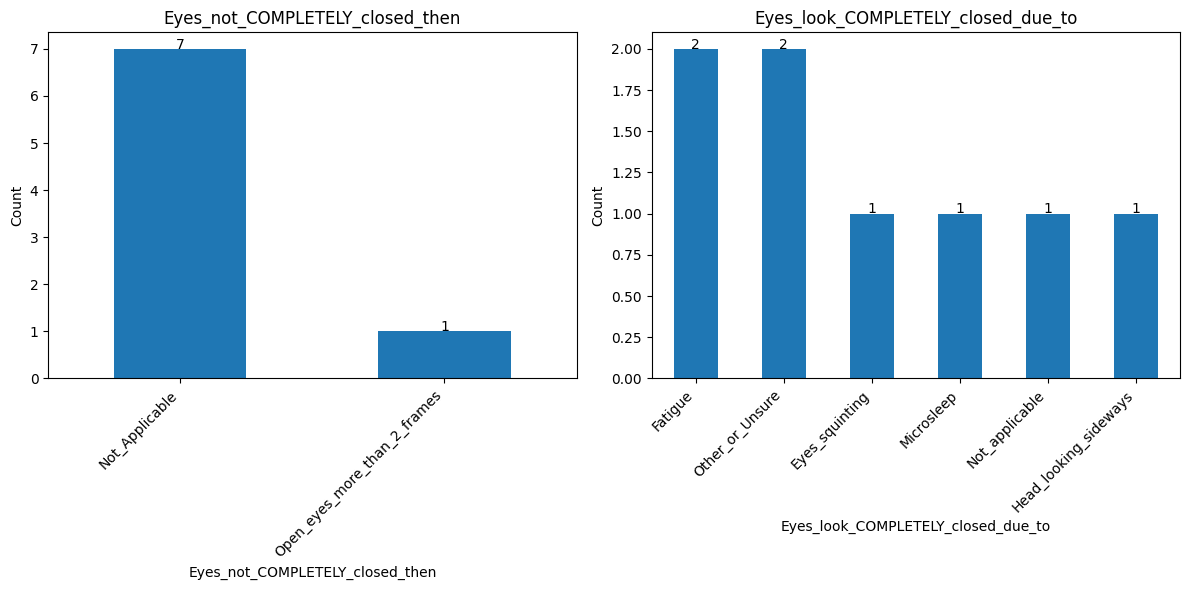

In [21]:
cond1 = (results_df['FN'] > 0)
temp = results_df[cond1]

# Create side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot first column
counts1 = temp['Eyes_not_COMPLETELY_closed_then'].value_counts()
bars1 = counts1.plot(kind='bar', ax=axs[0], title='Eyes_not_COMPLETELY_closed_then')
axs[0].bar_label(axs[0].containers[0], labels=[f'{v}' for v in counts1.values], fontsize=10, label_type='edge', padding=-2)
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

# Plot second column
counts2 = temp['Eyes_look_COMPLETELY_closed_due_to'].value_counts()
bars2 = counts2.plot(kind='bar', ax=axs[1], title='Eyes_look_COMPLETELY_closed_due_to')
axs[1].bar_label(axs[1].containers[0], labels=[f'{v}' for v in counts2.values], fontsize=10, label_type='edge', padding=-2)
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### True Negatives

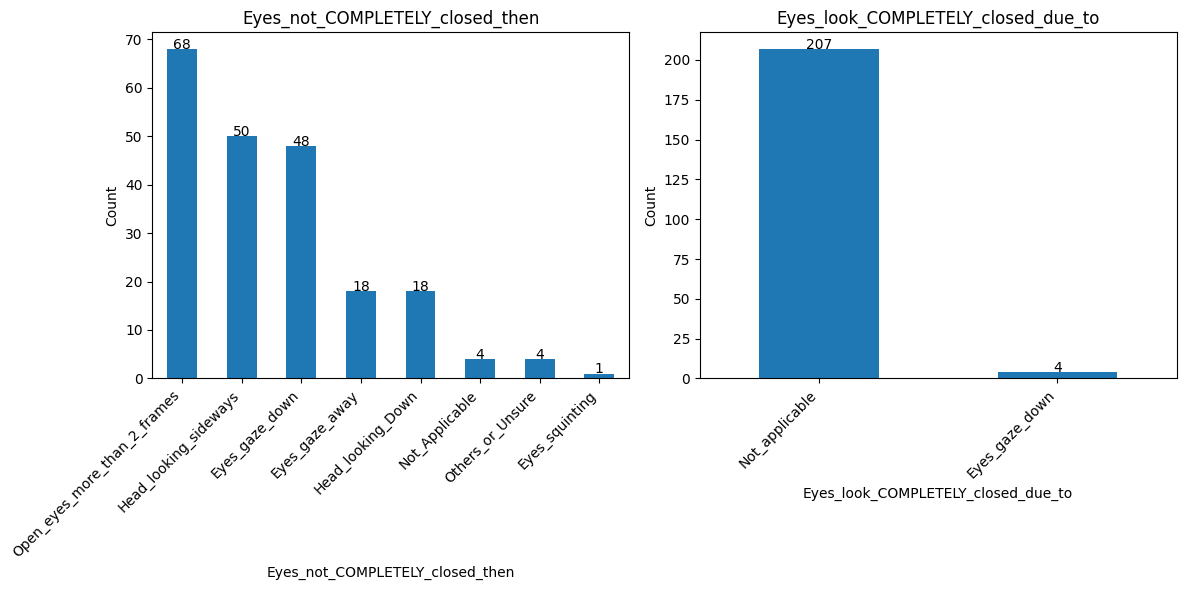

In [22]:
cond1 = (results_df['TN'] > 0)
temp = results_df[cond1]

# Create side-by-side bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot first column
counts1 = temp['Eyes_not_COMPLETELY_closed_then'].value_counts()
bars1 = counts1.plot(kind='bar', ax=axs[0], title='Eyes_not_COMPLETELY_closed_then')
axs[0].bar_label(axs[0].containers[0], labels=[f'{v}' for v in counts1.values], fontsize=10, label_type='edge', padding=-2)
axs[0].set_ylabel('Count')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

# Plot second column
counts2 = temp['Eyes_look_COMPLETELY_closed_due_to'].value_counts()
bars2 = counts2.plot(kind='bar', ax=axs[1], title='Eyes_look_COMPLETELY_closed_due_to')
axs[1].bar_label(axs[1].containers[0], labels=[f'{v}' for v in counts2.values], fontsize=10, label_type='edge', padding=-2)
axs[1].set_ylabel('Count')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [23]:
cond1 = (results_df['TN'] > 0)
cond2 = (results_df['annotation_alert_window_process_trigger'] >= 0.6)
temp = results_df[cond1 & cond2]
print(f"shape of temp: {temp.shape}")
temp[['uuid', 'is_not_ld', 'is_pose_valid', 'is_speed_met', 'annotation_alert_window_process_trigger', 'st_fidx', 'et_fidx', 'avid', 'Eyes_look_COMPLETELY_closed_due_to']][:50]

shape of temp: (4, 25)


,uuid,is_not_ld,is_pose_valid,is_speed_met,annotation_alert_window_process_trigger,st_fidx,et_fidx,avid,Eyes_look_COMPLETELY_closed_due_to
127,2368bae8-e8a2-4e69-b4fc-b765a3ac0558,False,False,True,1.0000,571,595,3adf5a6c-f358-4577-8107-734e65572dd8,Not_applicable
220,903de15d-21e1-4f5e-b731-c23c5ba549f0,-1,-1,-1,0.7143,425,443,989a49b0-f6eb-45ef-8934-12d697be43d4,Not_applicable
226,9b51618f-c040-4418-a482-bd1e0d939e21,-1,-1,-1,0.7143,107,127,977ab378-761b-420d-9055-ee866e6d041c,Not_applicable
253,c0078c2f-f607-413c-bba1-a344b03af403,True,False,True,0.8571,0,21,b2ca7aaf-5b3e-4fa7-b6d4-dd72776e4399,Not_applicable


### False Positives

In [24]:
cond1 = (results_df['FP'] > 0)
temp = results_df[cond1]
print(f"shape of temp: {temp.shape}")
temp[['uuid', 'is_not_ld', 'is_pose_valid', 'is_speed_met', 'annotation_alert_window_process_trigger', 'st_fidx', 'et_fidx', 'avid', 'Eyes_look_COMPLETELY_closed_due_to']][:50]

shape of temp: (3, 25)


,uuid,is_not_ld,is_pose_valid,is_speed_met,annotation_alert_window_process_trigger,st_fidx,et_fidx,avid,Eyes_look_COMPLETELY_closed_due_to
96,1c495b19-c0cf-47f9-bc2b-4ca2cf4124c6,True,True,True,0.8571,11,17,e1fb2696-79d0-4582-9147-eaecbe392bba,nan nan
110,1f112cce-a5b0-48e5-81aa-385f2e2368d8,True,True,True,1.0000,322,331,1fb5a841-c419-4176-a0a9-a21d9a5c7dca,nan nan
304,f01a077d-0ecf-43e9-a02c-d56ae1d9de38,True,True,True,0.8571,498,508,a59c2ab5-b1ae-4c64-9efa-82b2fd5b4d9f,Not_applicable
